# Plan of the practical session:
 - Application of the synthetic control using the `pysyncon` package and using a handmade basic SCM model. 

# Data
We extend the original CITS analyses by [Humphreys et al. (2017)](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2582988) using synthetic control methods (15 comparison states in the donor pool).
The code is inspired by the analyses in the original papers from [Degli Esposti et al., 2020](https://academic.oup.com/ije/article/49/6/2010/5917161#supplementary-data). It uses the data from (Bonander et al., 2021)[https://academic.oup.com/aje/article-abstract/190/12/2700/6336907].

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option("display.max_columns", None)

# Synthetic control method
First we set some constants.

In [2]:
URL2DATA = "https://raw.githubusercontent.com/strayMat/causal-ml-course/refs/heads/main/data/homicides_data.csv"

TREATED_COLOR = plt.get_cmap("tab10")(0)  # Default matplotlib blue
CONTROL_COLOR = plt.get_cmap("tab10")(1)  # Default matplotlib orange

COL_TREATMENT = "treatdummy"
COL_TREATED_UNIT = "Case"
TREATMENT_DATE = datetime(2005, 10, 1)
COL_TARGET = "HomicideRates"
RANDOM_SEED = 93572

Load the data and add a column with the Date format from the year and month columns homicides.

In [3]:
homicides = pd.read_csv(URL2DATA, index_col=0)
homicides["Month.string"] = homicides["Month.code"].apply(lambda x: f"{x:02d}")
homicides["Date"] = pd.to_datetime(
    homicides["Year"].astype(str) + "-" + homicides["Month.string"], format="%Y-%m"
)

In [4]:
# plotting utils
def plot_observed_data(
    data: pd.DataFrame,
    target_column: str = COL_TARGET,
    target_unit_name: str = "Florida",
    plot_all_controls: bool = False,
):
    """
    Plotting the data by treatment status.

    Args:
        data (pd.DataFrame): Observed data to plot
        plot_all_controls (bool): Whether to plot all control units or just the mean and sd for all control units.
    """

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # plot treated unit
    data_treated = data[data["State"] == target_unit_name]
    sns.lineplot(
        data=data_treated,
        x="Date",
        y=target_column,
        ax=ax,
        color=TREATED_COLOR,
        # marker="o",
        label=target_unit_name,
    )
    data_controls = data[data["State"] != target_unit_name]
    color_palette = {s: CONTROL_COLOR for s in data_controls["State"].unique()}
    if plot_all_controls:
        sns.lineplot(
            ax=ax,
            data=data_controls,
            x="Date",
            y=target_column,
            hue="State",
            palette=color_palette,
            alpha=0.7,
            # marker="o",
            linestyle="--",
        )
    # plot mean and sd for controls
    else:
        mean_controls = data_controls.groupby("Date")[COL_TARGET].mean()
        sd_controls = data_controls.groupby("Date")[COL_TARGET].std()
        ax.fill_between(
            mean_controls.index,
            mean_controls - sd_controls,
            mean_controls + sd_controls,
            color=CONTROL_COLOR,
            alpha=0.3,
        )
        ax.plot(mean_controls, color=CONTROL_COLOR, label="Control States")
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color=TREATED_COLOR, lw=2, label=target_unit_name),
            plt.Line2D([0], [0], color=CONTROL_COLOR, lw=2, label="Control States"),
        ]
    )
    # plot treatment date
    ax.axvline(TREATMENT_DATE, color="black", linestyle="--")
    return fig, ax


def plot_data_with_prediction(data: pd.DataFrame, y_pred, lower_ci=None, upper_ci=None):
    """
    Plotting a prediction with confidence intervals on top of the observed data.

    Args:
        data (pd.DataFrame): Observed data
        y_pred (_type_): Mean of the predicted values
        lower_ci (_type_): Lower bound of the confidence interval for the predicted values
        upper_ci (_type_): Upper bound of the confidence interval for the predicted values

    Returns:
        _type_: _description_
    """
    fig, ax = plot_observed_data(data)

    dates_to_predict = np.sort(data["Date"].unique())
    ax.plot(
        dates_to_predict,
        y_pred,
        color="black",
        linestyle="-.",
        label="Predicted Florida",
    )
    if lower_ci is not None and upper_ci is not None:
        ax.fill_between(
            dates_to_predict,
            lower_ci,
            upper_ci,
            color="black",
            alpha=0.3,
        )
    return fig, ax

## Visualize data 

### 📝 TODO Plot the follwoing subset of control states 

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='HomicideRates'>)

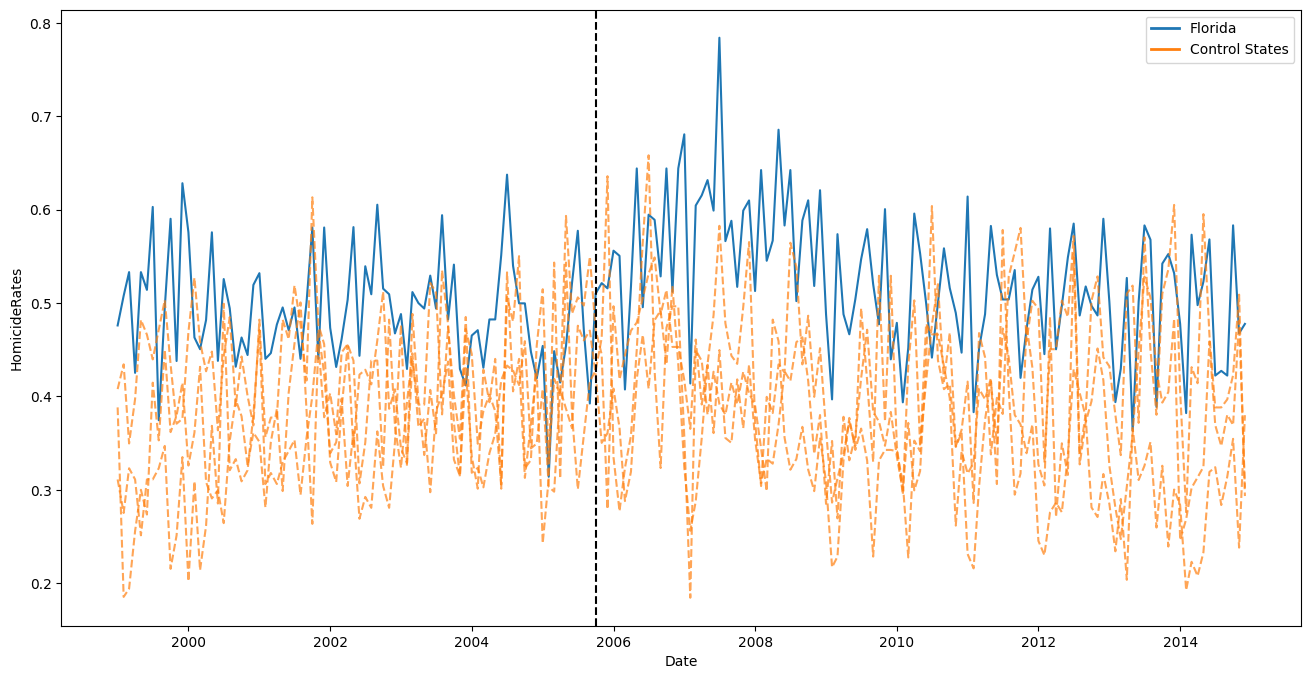

In [5]:
mask_subset_states = homicides["State"].isin(
    ["Florida", "New York", "New Jersey", "Ohio", "Virginia"]
)
# CODE HERE
homicides_subset = homicides[mask_subset_states]

plot_observed_data(homicides_subset, plot_all_controls=True)

### 📝 TODO Does the data seems consistent with the convex-hull assumption?
Find a subsest for which the convex-hull assumption do not seems to hold.
ANSWER HERE

### 📝 TODO plot the data that you have chosen with only the mean and standard deviation of the control units.

['Arkansas' 'Connecticut' 'Delaware' 'Florida' 'Hawaii' 'Iowa' 'Maine'
 'Maryland' 'Massachusetts' 'Nebraska' 'New Jersey' 'New York'
 'North Dakota' 'Ohio' 'Rhode Island' 'Wyoming']


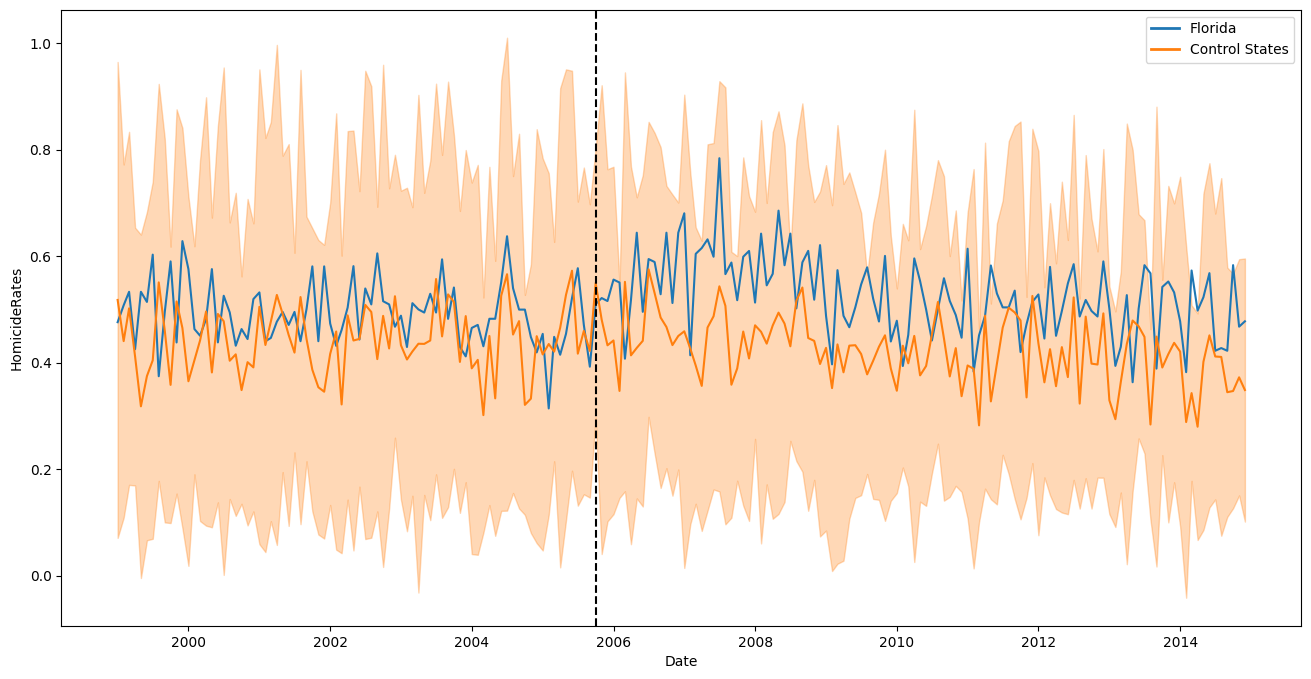

In [6]:
# CODE HERE
homicides_subset = homicides.copy()
plot_observed_data(homicides_subset, plot_all_controls=False)
print(homicides["State"].unique())

## Synthetic control by hand 
The following code cell gives a simple implementation of the synthetic control method using a convex optimization library to solve the SCM objective (without the inner optimization problem on the covariates).
We will first do the data preparation work for the synthetic control method and pass it to this handmade version of SCM.

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp
class SyntheticControl(BaseEstimator, RegressorMixin):
    """
    Synthetic Control Method (without the inner optimization problem).
    """
    def __init__(
        self,
    ):
        pass

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X @ w - y))

        constraints = [cp.sum(w) == 1, w >= 0]

        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)

        self.X_ = X
        self.y_ = y
        self.w_ = w.value

        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        return X @ self.w_

### 📝 TODO Prepare the data for the synthetic control method. 

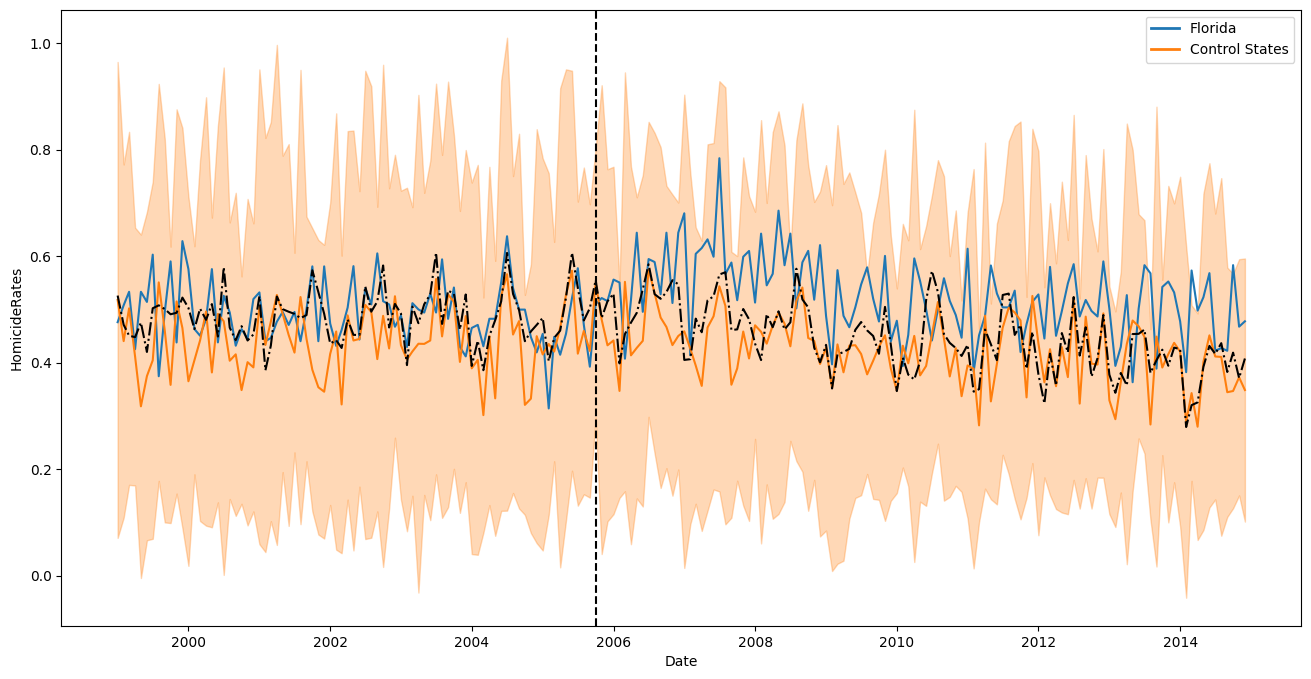

In [8]:
# CODE HERE
mask_treated = homicides_subset["State"] == "Florida"
mask_pre_treatment = homicides_subset["Date"] < TREATMENT_DATE

control_units = homicides_subset[~mask_treated]
treated_unit = homicides_subset[mask_treated]
Y_control = control_units.pivot(index="Date", columns="State", values=[COL_TARGET])
Y_treated = treated_unit[COL_TARGET]

Y_pretreatment_control = control_units.loc[
    control_units["Date"] < TREATMENT_DATE
].pivot(index="Date", columns="State", values=[COL_TARGET])

Y_pretreatment_treated = treated_unit.loc[
    treated_unit["Date"] < TREATMENT_DATE, COL_TARGET
]


temporal_covariates = [COL_TARGET]  # , "Unemployment_adj"]
static_covariates = [
    "Burglary.rate",
    "Population",
    "Personal.income.per.capita..dollars.",
    "Paid.Hunting.License.Holders",
]

pretreatment_controls = homicides_subset[(~mask_treated) & mask_pre_treatment]
pretreatment_treated = homicides_subset[mask_treated & mask_pre_treatment]

control_covariates_list = []
treated_covariates_list = []
for cov in temporal_covariates:
    control_covariates_list.append(
        pretreatment_controls.pivot(index="Date", columns="State", values=cov)
    )

    treated_covariates_list.append(
        pretreatment_treated.pivot(
            index="Date", columns="State", values=temporal_covariates
        ).iloc[:, 0]
    )
control_static_covariates_list = []
treated_static_covariates_list = []
for cov in static_covariates:
    control_static_covariates_list.append(
        control_units.pivot(index="Date", columns="State", values=cov).iloc[0, :].T
    )
    treated_static_covariates_list.append(
        treated_unit.pivot(index="Date", columns="State", values=cov).iloc[0, :]
    )
control_static_covariates = pd.concat(control_static_covariates_list, axis=1).T
treated_static_covariates = pd.concat(treated_static_covariates_list, axis=0)
control_covariates = pd.concat(
    (pd.concat(control_covariates_list, axis=0), control_static_covariates), axis=0
)
treated_covariates = pd.concat(
    (pd.concat(treated_covariates_list, axis=0), treated_static_covariates), axis=0
)
my_synth = SyntheticControl()
my_synth.fit(Y_pretreatment_control, Y_pretreatment_treated)
y_pred = my_synth.predict(Y_control)
# 
fig, ax = plot_observed_data(homicides_subset, plot_all_controls=False)
ax.plot(np.sort(homicides_subset["Date"].unique()), y_pred, color="black", linestyle="-.")

## Use a SCM package to do all the heavy preparation work
### 📝 TODO: Prepare the data for the synthetic control method using the `pysyncon` package. Go to the [documentation](https://pysyncon.readthedocs.io/en/latest/) to see how to use the package.
- First, use only `HomicideRates` as the target variable.

In [9]:
from pysyncon import Synth, Dataprep

control_state_names = [state_name for state_name in homicides_subset["State"].unique() if state_name != "Florida"]
time_range = np.sort(homicides_subset["Date"].unique())
time_range_prior = time_range[time_range < pd.to_datetime(TREATMENT_DATE)]

In [10]:
# CODE HERE
dataprep_train = Dataprep(
    foo=homicides_subset,
    predictors=[COL_TARGET, "Unemployment_adj", "Firearm.suicides", "Personal.income.per.capita..dollars.", "Annual.incarceration.rate", "Num_pop_over15", "Percentage.4.year.bachelors.or.above..25.years.old.and.over"],
    predictors_op="mean",
    time_predictors_prior=time_range_prior,
    dependent=COL_TARGET,
    unit_variable="State",
    time_variable="Date",
    treatment_identifier="Florida",
    controls_identifier=control_state_names,
    time_optimize_ssr=time_range_prior
)

### TODO 📝Fit the model

In [11]:
# CODE HERE
synth = Synth()
synth.fit(
    dataprep=dataprep_train,
    optim_method="Nelder-Mead",
    optim_initial="equal",
    
)
y_pred = Y_control @ synth.W.T

Let's visualize the results of the synthetic control method.

In [12]:
print("Weights of the synthetic control predictor (w vector for the inner optimization loop):\n")
print(synth.weights())
print("Summary of the predictor importances (V diagonal matrix for the outer optimization loop):\n")
print(synth.summary())
scores = pd.DataFrame({"mae": [synth.mae()], "mape": [synth.mape()], "mse": [synth.mspe()]})
print(f"Pre-treatment fit scores:\n {scores}")

Weights of the synthetic control predictor (w vector for the inner optimization loop):

Arkansas         0.296
Connecticut      0.000
Delaware         0.029
Hawaii           0.050
Iowa             0.000
Maine            0.000
Maryland         0.000
Massachusetts    0.000
Nebraska         0.000
New Jersey       0.000
New York         0.626
North Dakota     0.000
Ohio             0.000
Rhode Island     0.000
Wyoming          0.000
Name: weights, dtype: float64
Summary of the predictor importances (V diagonal matrix for the outer optimization loop):

                                                        V       treated  \
HomicideRates                                       0.255  4.910000e-01   
Unemployment_adj                                    0.092  7.619000e+00   
Firearm.suicides                                    0.007  9.932100e+01   
Personal.income.per.capita..dollars.                0.148  3.162371e+04   
Annual.incarceration.rate                           0.087  4.647140e+02

### TODO 📝 Plot the results of the synthetic control method using the `plot_observed_data` function. 

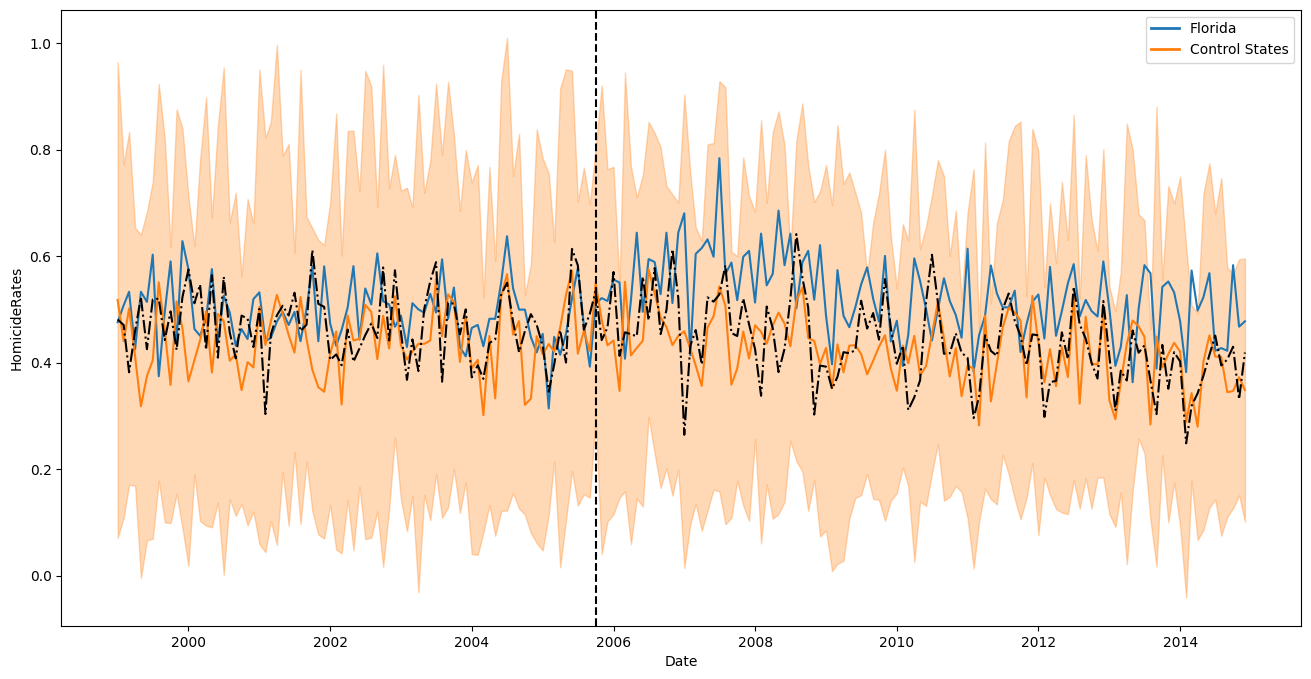

In [13]:
# CODE HERE
fig, ax = plot_observed_data(homicides_subset, plot_all_controls=False)
ax.plot(np.sort(homicides_subset["Date"].unique()), y_pred, color="black", linestyle="-.")

The `pysyncon` package also provides a method to visualize the results.

In [14]:
# ### 📝 TODO Use the `pysyncon` package to visualize the same results. 

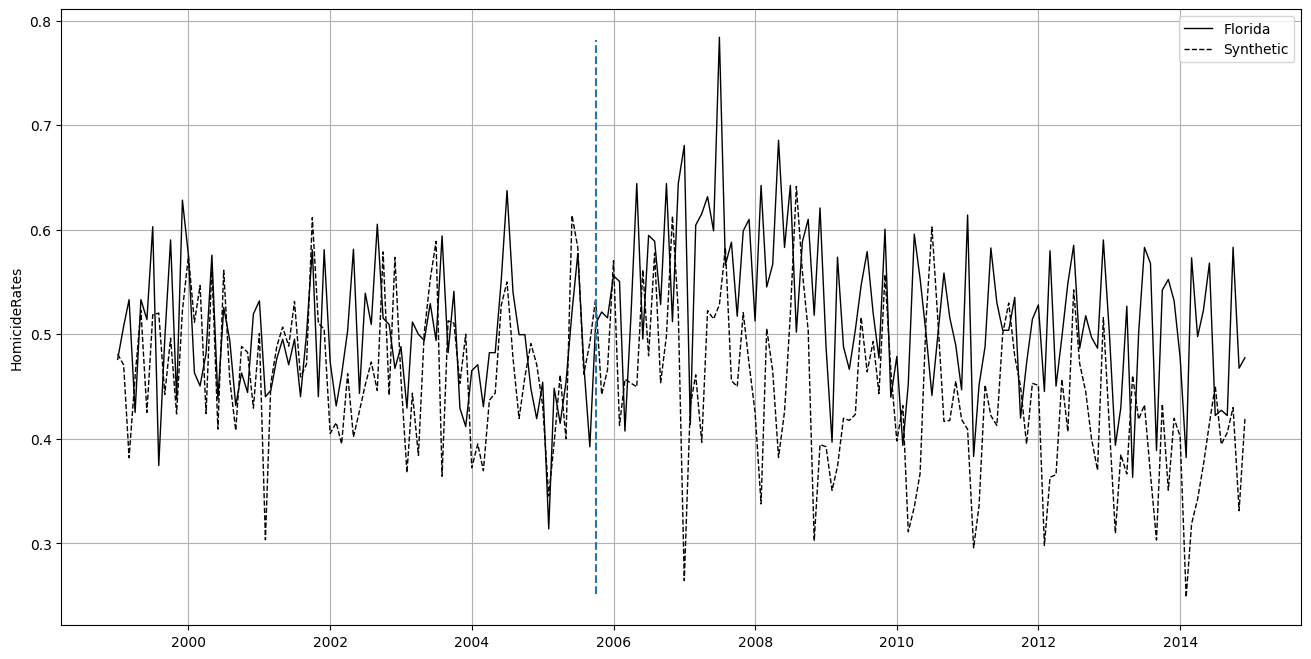

In [15]:
# CODE HERE
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
synth.path_plot(treatment_time=TREATMENT_DATE, time_period=time_range)

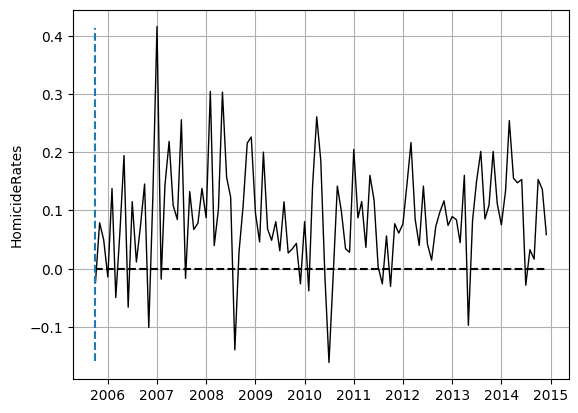

In [16]:
# Another plot in the package, focusing on the effect between the treated and synthetic control units.
time_range_postorior = time_range[time_range >= pd.to_datetime(TREATMENT_DATE)]
synth.gaps_plot(time_period=time_range_postorior, treatment_time=TREATMENT_DATE)

## Include some predictors in the model.
Until now, we did not make use of the predictors in the dataset, so the outer optimization loop (with the V diagonal matrix) was not used. We will now include some predictors in the model.

### 📝 TODO Re-run the data preparation, fit, result summary and plot steps but with more predictors in the model (choose predictors that you find appopriate in the homicide dataset columns).

In [17]:
# dataprep_train
dataprep_train = Dataprep(
    foo=homicides_subset,
    predictors=[COL_TARGET, "Unemployment_adj", "Firearm.suicides", "Personal.income.per.capita..dollars.", "Annual.incarceration.rate", "Num_pop_over15", "Percentage.4.year.bachelors.or.above..25.years.old.and.over"],
    predictors_op="mean",
    time_predictors_prior=time_range_prior,
    dependent=COL_TARGET,
    unit_variable="State",
    time_variable="Date",
    treatment_identifier="Florida",
    controls_identifier=control_state_names,
    time_optimize_ssr=time_range_prior
)

### TODO 📝Fit the model

In [18]:
# CODE HERE
synth = Synth()
synth.fit(
    dataprep=dataprep_train,
    optim_method="Nelder-Mead",
)
y_pred = Y_control @ synth.W.T

Let's visualize the results of the synthetic control method.

In [19]:
print("Weights of the synthetic control predictor (w vector for the inner optimization loop):\n")
print(synth.weights())
print("Summary of the predictor importances (V diagonal matrix for the outer optimization loop):\n")
print(synth.summary())
scores = pd.DataFrame({"mae": [synth.mae()], "mape": [synth.mape()], "mse": [synth.mspe()]})
print(f"Pre-treatment fit scores:\n {scores}")

Weights of the synthetic control predictor (w vector for the inner optimization loop):

Arkansas         0.296
Connecticut      0.000
Delaware         0.029
Hawaii           0.050
Iowa             0.000
Maine            0.000
Maryland         0.000
Massachusetts    0.000
Nebraska         0.000
New Jersey       0.000
New York         0.626
North Dakota     0.000
Ohio             0.000
Rhode Island     0.000
Wyoming          0.000
Name: weights, dtype: float64
Summary of the predictor importances (V diagonal matrix for the outer optimization loop):

                                                        V       treated  \
HomicideRates                                       0.255  4.910000e-01   
Unemployment_adj                                    0.092  7.619000e+00   
Firearm.suicides                                    0.007  9.932100e+01   
Personal.income.per.capita..dollars.                0.148  3.162371e+04   
Annual.incarceration.rate                           0.087  4.647140e+02

### TODO 📝 Plot the results of the synthetic control method using the `plot_observed_data` function. 

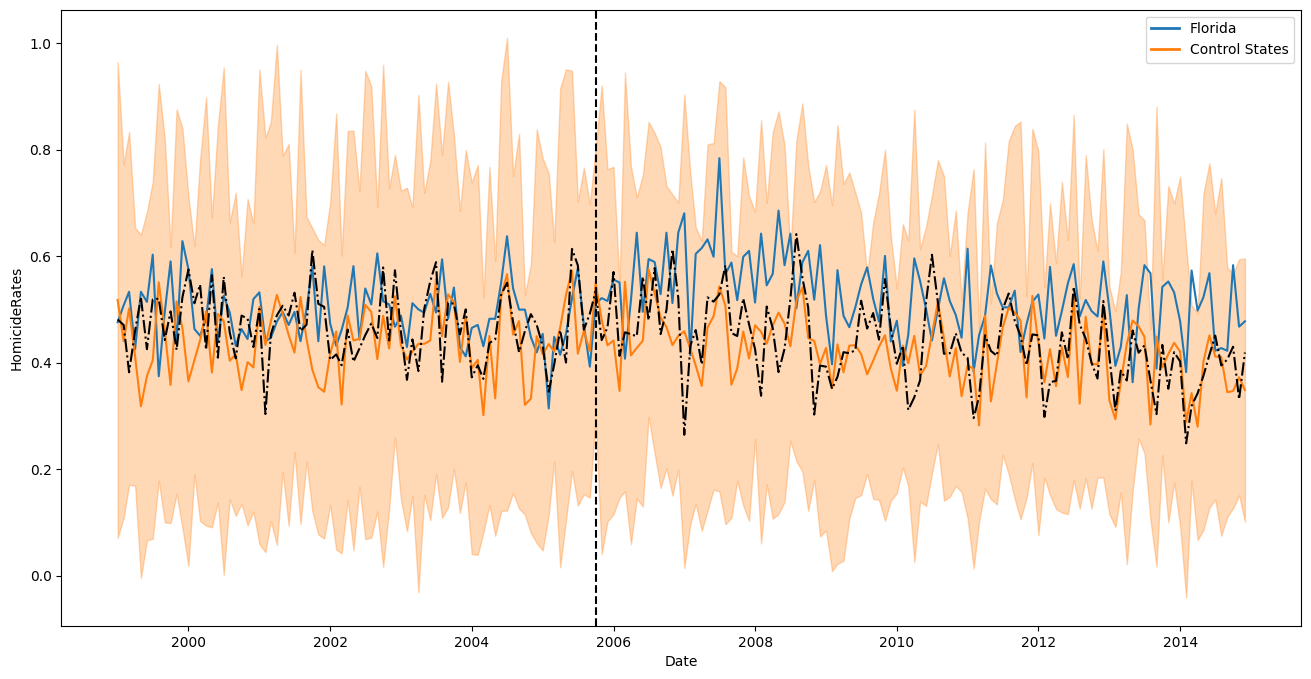

In [20]:
# CODE HERE
fig, ax = plot_observed_data(homicides_subset, plot_all_controls=False)
ax.plot(np.sort(homicides_subset["Date"].unique()), y_pred, color="black", linestyle="-.")
# CODE HERE

## 📝 TODO What model do you find more convincing between both (without or with predictors)? Why ? 
ANSWER HERE

## Placebo tests 
We can run placebo tests to assess the validity of the synthetic control method. This can be easily done with the `pysyncon` package. 
### 📝 TODO Run a placebo test with the `pysyncon` package.

In [21]:
# CODE HERE 
from pysyncon.utils import PlaceboTest

placebo_test = PlaceboTest()
placebo_test.fit(dataprep=dataprep_train, scm=synth, max_workers=8)
placebo_test.pvalue(treatment_time=TREATMENT_DATE)

(1/15) Completed placebo test for Connecticut.


(2/15) Completed placebo test for Massachusetts.


(3/15) Completed placebo test for Maine.


(4/15) Completed placebo test for Nebraska.


(5/15) Completed placebo test for New York.
(6/15) Completed placebo test for Iowa.


(7/15) Completed placebo test for New Jersey.
(8/15) Completed placebo test for Ohio.


(9/15) Completed placebo test for Maryland.
(10/15) Completed placebo test for Delaware.


(11/15) Completed placebo test for Arkansas.


(12/15) Completed placebo test for Hawaii.


(13/15) Completed placebo test for North Dakota.
(14/15) Completed placebo test for Wyoming.


(15/15) Completed placebo test for Rhode Island.
Calculating treated unit gaps.


Done.


0.0

We can plot the gaps for each placebo unit. We chose to exclude the placebo units that have a pre-treatment mean squared prediction error above a certain threshold (here 5).
For this unit, the model is not able to predict the pre-treatment period well, so the post treatment gap is not reliable.
plt.figure(figsize=(16, 8))
placebo_test.gaps_plot(time_period=time_range, treatment_time=TREATMENT_DATE, mspe_threshold=5)

### 📝 TODO Draw the histogram of the mean squared Average treatment effect post-treatment. 

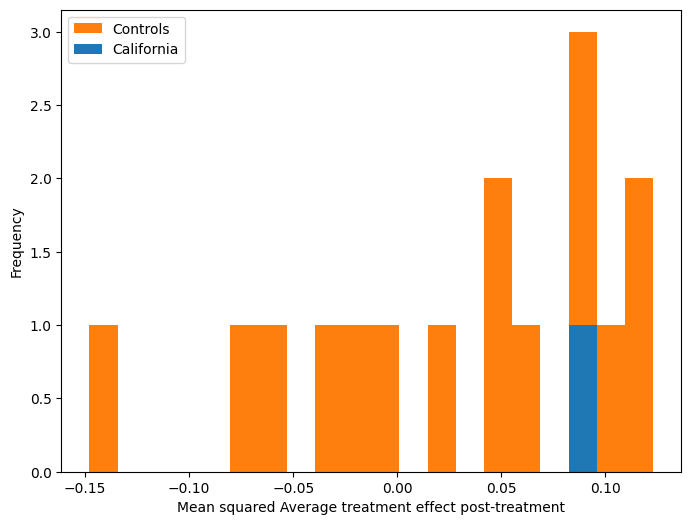

In [22]:
# CODE HERE
control_post_treatment_gaps = placebo_test.gaps[placebo_test.gaps.index >= TREATMENT_DATE]
control_post_treatment_att_mean_squared = control_post_treatment_gaps.mean(axis=0)

treated_post_treatment_att_mean_squared = pd.Series(placebo_test.treated_gap[placebo_test.treated_gap.index >= TREATMENT_DATE].mean(axis=0), index=["Florida"])

all_post_treatment_att_mean_squared = pd.concat([control_post_treatment_att_mean_squared, treated_post_treatment_att_mean_squared], axis=0).sort_values()

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
a_, bins, _ = ax.hist(all_post_treatment_att_mean_squared, bins=20, label="Controls", color=CONTROL_COLOR)
ax.set_ylabel("Frequency")
ax.set_xlabel("Mean squared Average treatment effect post-treatment")
ax.hist(
    [treated_post_treatment_att_mean_squared], bins=bins, color=TREATED_COLOR, label="California"
)
plt.legend(loc="upper left")

## 📝 TODO Draw the histogram of the mean squared Average treatment effect post-treatment but this time by excluding control units having a pre-treatment mean squared prediction error greater than 5 times the one of the treated unit. 

Excluded units: ['Maryland', 'North Dakota']


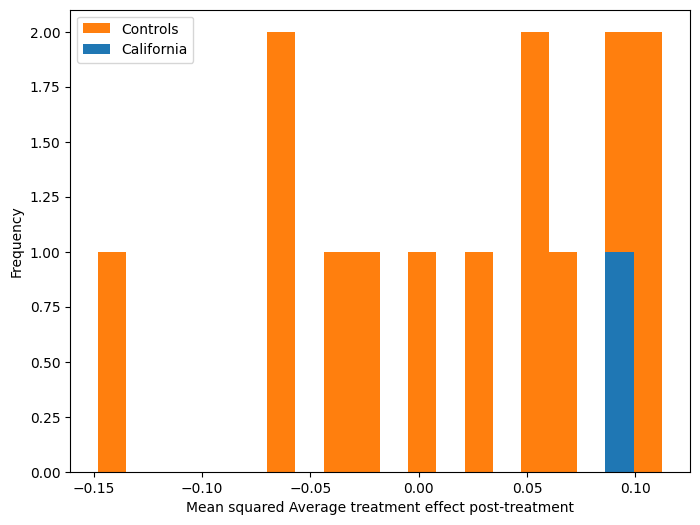

In [23]:
# CODE HERE
control_pre_treatment_att_mean_squared = placebo_test.gaps[placebo_test.gaps.index < TREATMENT_DATE].mean(axis=0)

treated_mspe_pre_treatment = placebo_test.treated_gap[placebo_test.treated_gap.index < TREATMENT_DATE].mean(axis=0)

mspe_threshold = 5
excluded_units = [control_ for control_ in control_pre_treatment_att_mean_squared.index if control_pre_treatment_att_mean_squared[control_] > mspe_threshold* treated_mspe_pre_treatment]
print(f"Excluded units: {excluded_units}")

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
a_, bins, _ = ax.hist(all_post_treatment_att_mean_squared.drop(excluded_units), bins=20, label="Controls", color=CONTROL_COLOR)
ax.set_ylabel("Frequency")
ax.set_xlabel("Mean squared Average treatment effect post-treatment")
ax.hist(
    [treated_post_treatment_att_mean_squared], bins=bins, color=TREATED_COLOR, label="California"
)
plt.legend(loc="upper left")